Random forest model using latitude and longitude, just environmental features, and using spatial lag

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

import libpysal
from libpysal.weights import Queen




In [2]:
# Load in features data
features_df = pd.read_csv('CS4824CapstoneData/features.csv')

In [3]:
print("Shape:", features_df.shape)


print("\nInfested counties ratio:")
print(features_df["infested"].value_counts(normalize=True))

Shape: (3144, 8)

Infested counties ratio:
infested
0    0.933524
1    0.066476
Name: proportion, dtype: float64


In [4]:
# First model uses county latitude and longitude
feature_cols = [
    "TreeOfHeaven_Present",
    "urban_code_num",
    "urban_effective",
    "centroid_lat",
    "centroid_lon",
]
target_col = "infested"

X = features_df[feature_cols]
y = features_df[target_col]

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
print(f"Infested ratio (train): {y_train.mean():.3f}")


Train size: 2515, Test size: 629
Infested ratio (train): 0.066


In [5]:
# random forest model
rf = RandomForestClassifier(
    n_estimators=300,             
    max_depth=None,              
    random_state=42,
    class_weight="balanced_subsample",  
    n_jobs=-1,                  
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', n_estimators=300,
                       n_jobs=-1, random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0      0.981     0.988     0.985       587
           1      0.816     0.738     0.775        42

    accuracy                          0.971       629
   macro avg      0.899     0.863     0.880       629
weighted avg      0.970     0.971     0.971       629



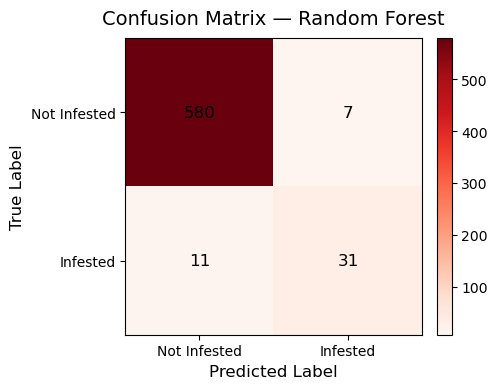

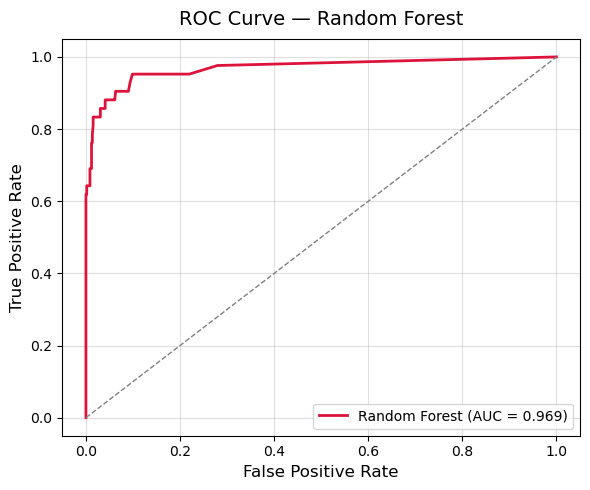

In [6]:
# Predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

features_df['predicted_proba'] = rf.predict_proba(X)[:, 1]


print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Reds")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=12)

ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
ax.set_title("Confusion Matrix — Random Forest", fontsize=14, pad=10)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Not Infested", "Infested"])
ax.set_yticks([0, 1])
ax.set_yticklabels(["Not Infested", "Infested"])
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# ROC curve
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='crimson', lw=2, label=f"Random Forest (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve — Random Forest", fontsize=14, pad=10)
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

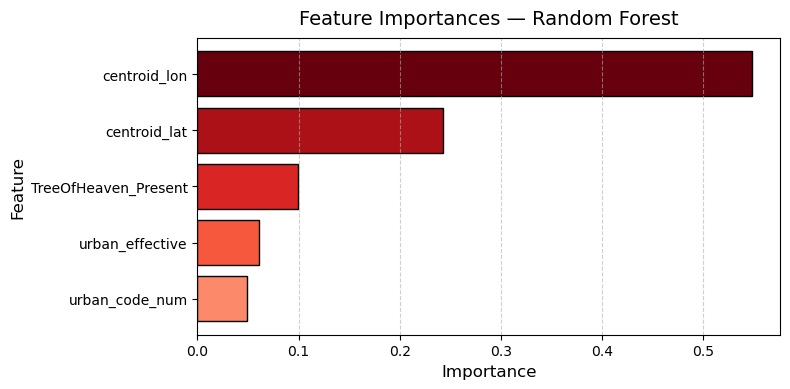

urban_code_num          0.049106
urban_effective         0.061007
TreeOfHeaven_Present    0.099087
centroid_lat            0.242306
centroid_lon            0.548494
dtype: float64


In [7]:
# Sort feature importances
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=True)

# Create color gradient (light red → dark red)
colors = plt.cm.Reds(np.linspace(0.4, 1, len(importances)))

plt.figure(figsize=(8, 4))
plt.barh(importances.index, importances.values, color=colors, edgecolor='black')
plt.title("Feature Importances — Random Forest", fontsize=14, pad=10)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print(importances)

In [8]:
# Second model only using ecological features and not lat or lon
env_features = ["TreeOfHeaven_Present", "urban_code_num", "urban_effective"]


In [9]:
rf_env = RandomForestClassifier(
    class_weight="balanced_subsample",
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)

rf_env.fit(X_train[env_features], y_train)


RandomForestClassifier(class_weight='balanced_subsample', n_estimators=300,
                       n_jobs=-1, random_state=42)

In [10]:
y_pred_env = rf_env.predict(X_test[env_features])
y_prob_env = rf_env.predict_proba(X_test[env_features])[:, 1]


In [11]:
print("Accuracy (No Coordinates):", accuracy_score(y_test, y_pred_env))
print("\nClassification Report (No Coordinates):")
print(classification_report(y_test, y_pred_env))


Accuracy (No Coordinates): 0.8585055643879174

Classification Report (No Coordinates):
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       587
           1       0.29      0.79      0.43        42

    accuracy                           0.86       629
   macro avg       0.64      0.82      0.67       629
weighted avg       0.94      0.86      0.89       629



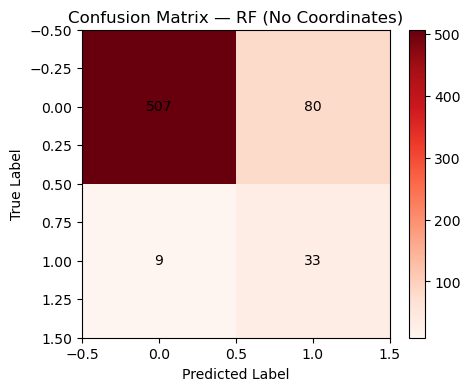

In [12]:
# Confusion matrix
cm_env = confusion_matrix(y_test, y_pred_env)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_env, cmap="Reds")

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix — RF (No Coordinates)")

for i in range(cm_env.shape[0]):
    for j in range(cm_env.shape[1]):
        ax.text(j, i, cm_env[i, j], ha="center", va="center", color="black")

plt.colorbar(im)
plt.show()


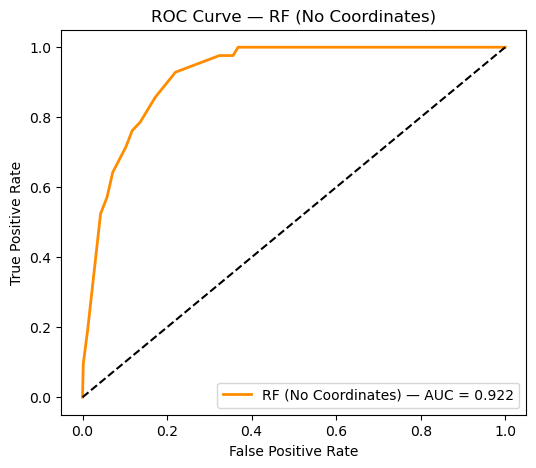

In [13]:
# ROC curve
fpr_env, tpr_env, _ = roc_curve(y_test, y_prob_env)
auc_env = roc_auc_score(y_test, y_prob_env)

plt.figure(figsize=(6, 5))
plt.plot(fpr_env, tpr_env, color="darkorange", lw=2, label=f"RF (No Coordinates) — AUC = {auc_env:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — RF (No Coordinates)")
plt.legend()
plt.show()


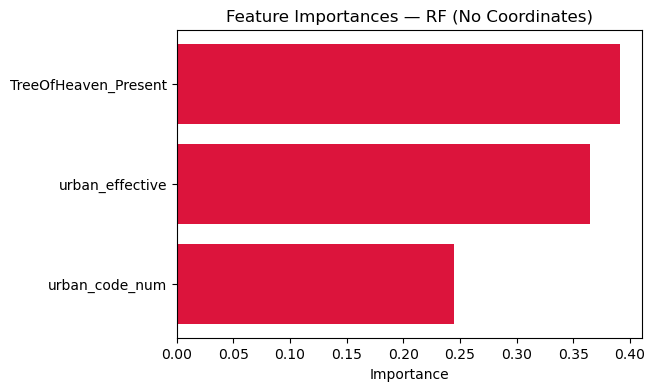

TreeOfHeaven_Present    0.391076
urban_effective         0.364617
urban_code_num          0.244307
dtype: float64


In [14]:
# Plot importances
importances_env = pd.Series(rf_env.feature_importances_, index=env_features).sort_values(ascending=False)

plt.figure(figsize=(6, 4))
plt.barh(importances_env.index, importances_env.values, color="crimson")
plt.title("Feature Importances — RF (No Coordinates)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

print(importances_env)


In [15]:
# Load counties dataset
counties_gdf = gpd.read_file('CS4824CapstoneData/tl_2025_us_county/tl_2025_us_county.shp')

In [16]:
# Merge counties shapefile with predictions
counties_gdf['GEOID'] = counties_gdf['GEOID'].astype(int)
features_df['GEOID'] = features_df['GEOID'].astype(int)

merged_gdf = counties_gdf.merge(
    features_df,
    on="GEOID",  
    how="left"
)

# Must be a geodataframe to plot
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry="geometry", crs=counties_gdf.crs)

print("Merged shape:", merged_gdf.shape)


Merged shape: (3235, 27)


In [17]:
# Just use continental united states
non_conus_fips = ["02", "15", "60", "66", "69", "72", "78"]
conus_gdf = merged_gdf[~merged_gdf["STATEFP"].isin(non_conus_fips)].copy()

print("CONUS subset:", conus_gdf.shape)



CONUS subset: (3109, 27)


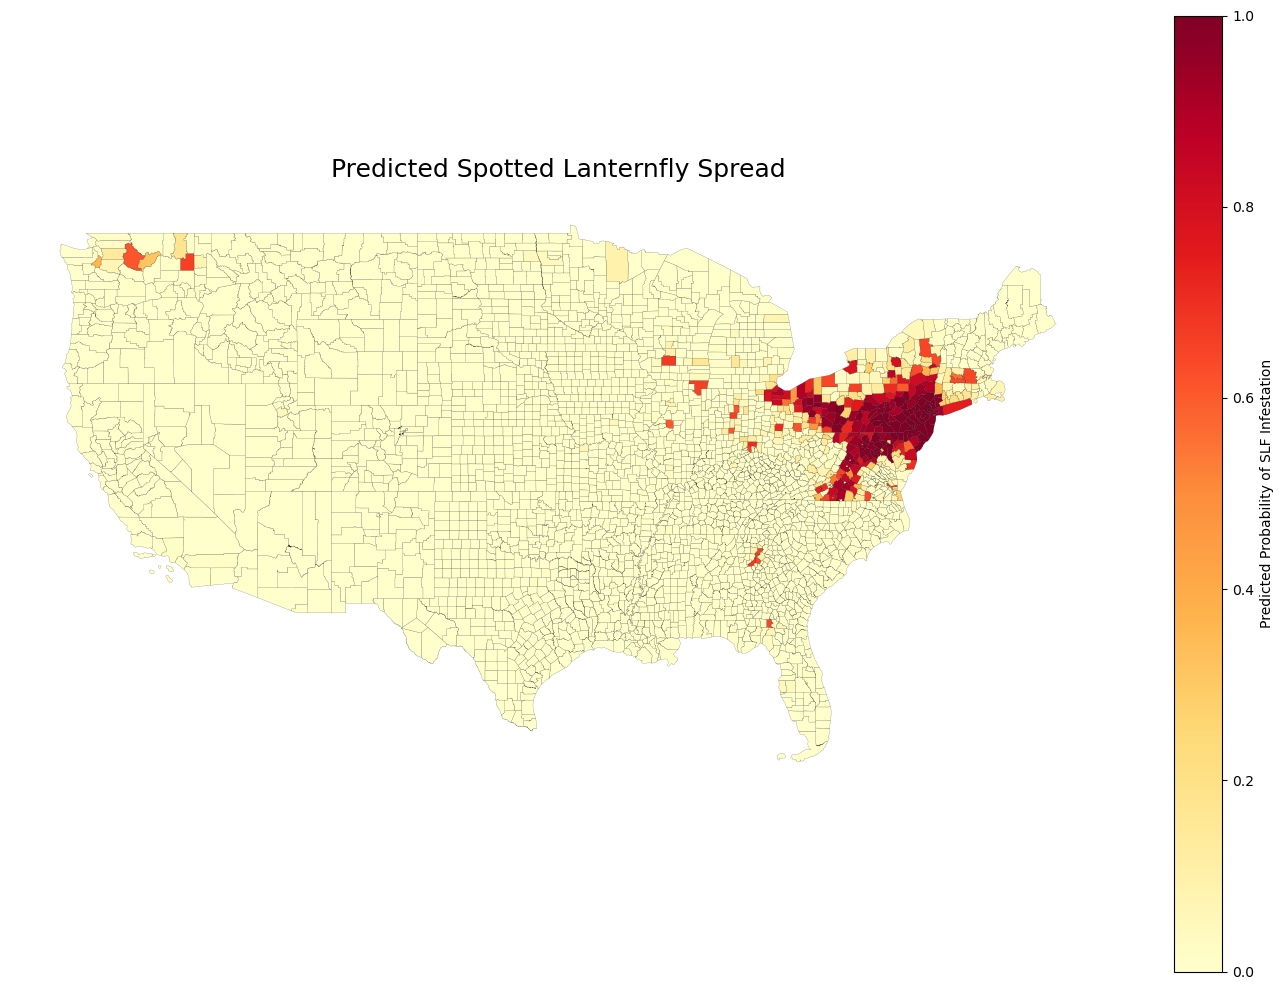

In [18]:
# Plot predicted infestation map for Lat and Lon model

fig, ax = plt.subplots(figsize=(14, 10))

conus_gdf.plot(
    column="predicted_proba",
    cmap="YlOrRd",
    linewidth=0.1,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "Predicted Probability of SLF Infestation",
        "orientation": "vertical"
    },
    ax=ax
)

ax.set_title("Predicted Spotted Lanternfly Spread", fontsize=18, pad=15)
ax.axis("off")
plt.tight_layout()
plt.show()


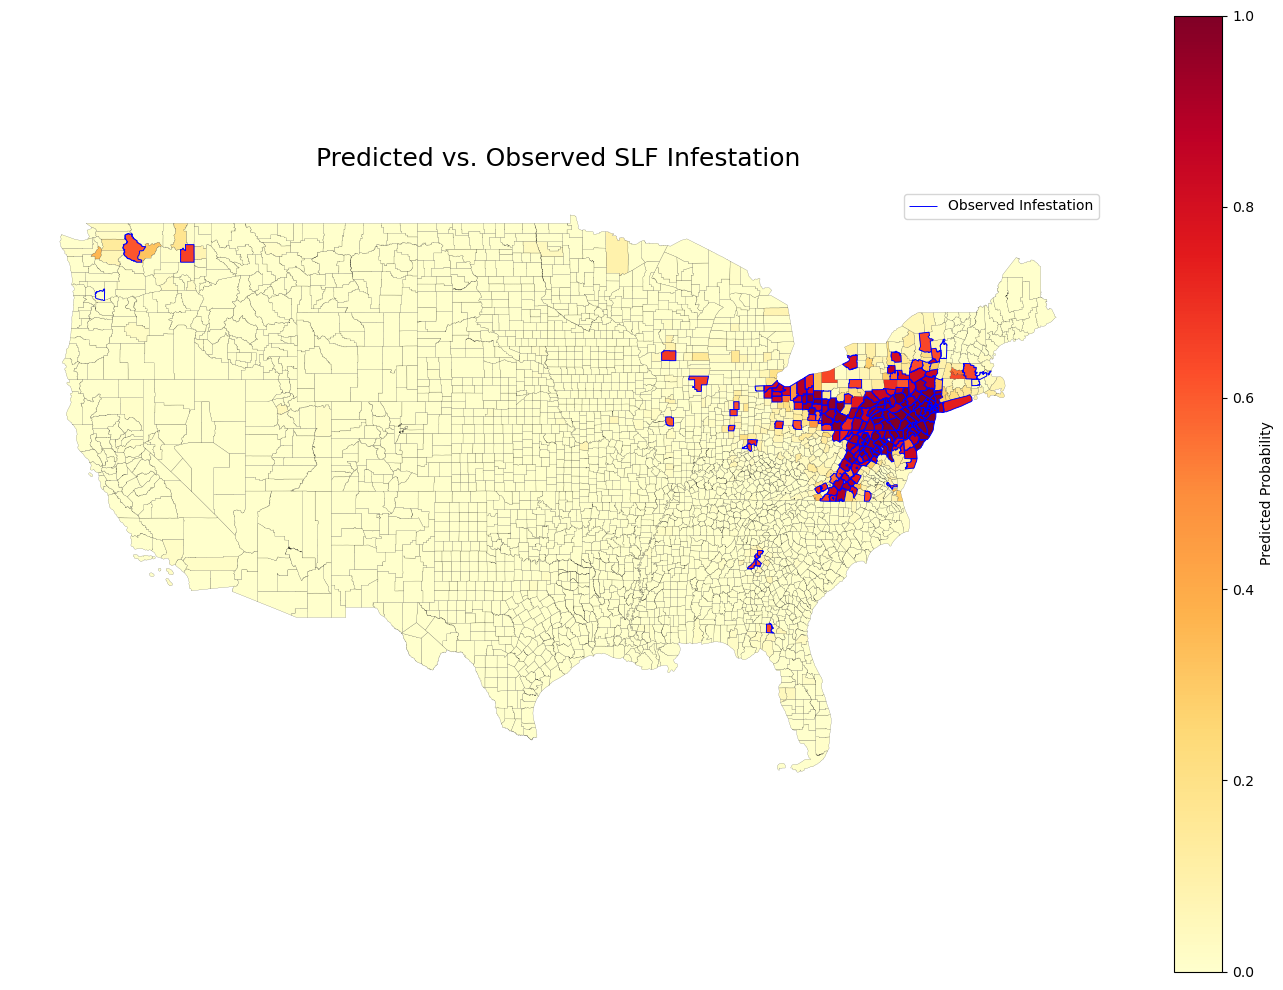

In [19]:

fig, ax = plt.subplots(figsize=(14, 10))

# Base = predicted infestation
conus_gdf.plot(
    column="predicted_proba",
    cmap="YlOrRd",
    linewidth=0.1,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Predicted Probability"},
    ax=ax
)

# Overlay test counties that are infested
conus_gdf[conus_gdf["infested"] == 1].boundary.plot(
    ax=ax, color="blue", linewidth=0.7, label="Observed Infestation"
)

ax.set_title("Predicted vs. Observed SLF Infestation", fontsize=18, pad=15)
ax.legend()
ax.axis("off")
plt.tight_layout()
plt.show()


In [20]:
# Add no coordinate predictions to features_df
features_df["predicted_proba_env"] = rf_env.predict_proba(X[env_features])[:, 1]


In [21]:
# Merge features and shapefile
merged_gdf = counties_gdf.merge(features_df, on="GEOID", how="left")

# Filter out non conus regions
non_conus_fips = ["02", "15", "60", "66", "69", "72", "78"]
conus_gdf = merged_gdf[~merged_gdf["STATEFP"].isin(non_conus_fips)].copy()


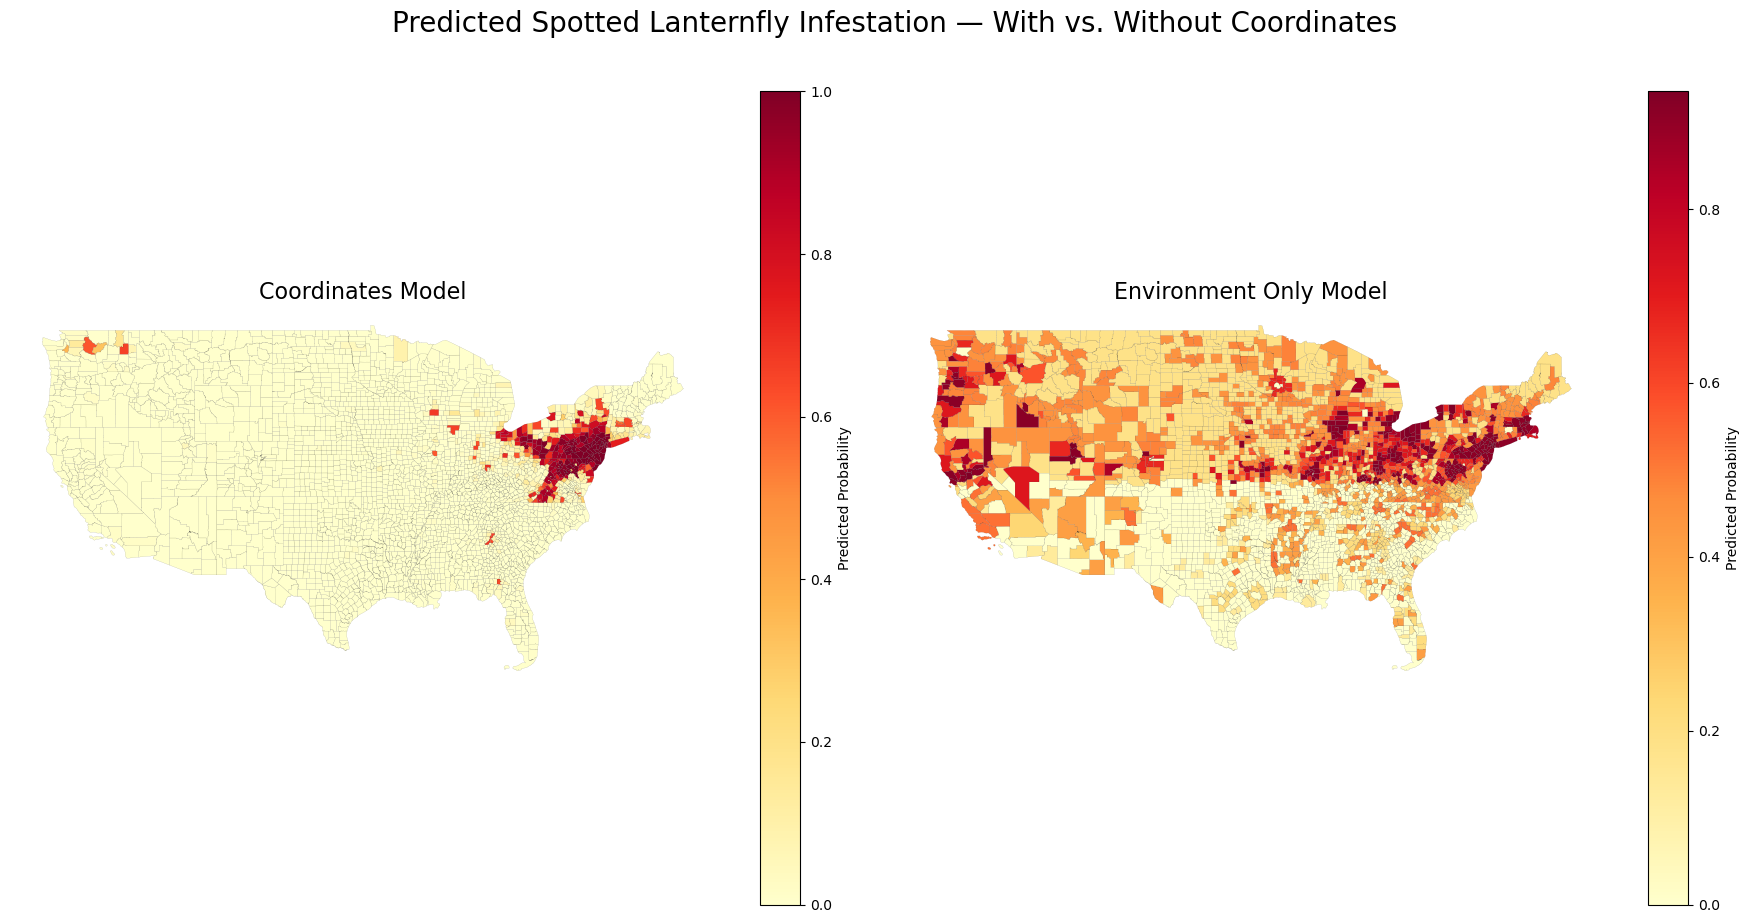

In [22]:
# Side by side comparison plot 
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Coordinates model
conus_gdf.plot(
    column="predicted_proba",
    cmap="YlOrRd",
    linewidth=0.05,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Predicted Probability"},
    ax=axes[0]
)
axes[0].set_title("Coordinates Model", fontsize=16)
axes[0].axis("off")

# Environment only model
conus_gdf.plot(
    column="predicted_proba_env",
    cmap="YlOrRd",
    linewidth=0.05,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Predicted Probability"},
    ax=axes[1]
)
axes[1].set_title("Environment Only Model", fontsize=16)
axes[1].axis("off")

plt.suptitle("Predicted Spotted Lanternfly Infestation — With vs. Without Coordinates", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


<Figure size 1000x700 with 0 Axes>

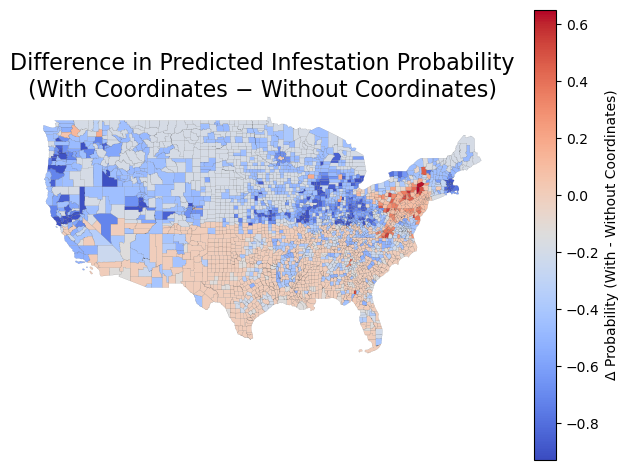

In [23]:
# Difference map
# Compute difference
conus_gdf["pred_diff"] = conus_gdf["predicted_proba"] - conus_gdf["predicted_proba_env"]

# Plot difference
plt.figure(figsize=(10, 7))
conus_gdf.plot(
    column="pred_diff",
    cmap="coolwarm",
    linewidth=0.05,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Δ Probability (With - Without Coordinates)"},
)
plt.title("Difference in Predicted Infestation Probability\n(With Coordinates − Without Coordinates)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


In [24]:
#model with spatial lag instead of coordinates


# Filter out non conus
non_conus_fips = ["02", "15", "60", "66", "69", "72", "78"]
conus_gdf = counties_gdf[~counties_gdf["STATEFP"].isin(non_conus_fips)].copy()

# Compute Queen contiguity weights 
w = Queen.from_dataframe(conus_gdf)
w.transform = "r" 


conus_gdf = conus_gdf.merge(
    features_df[["GEOID", "infested"]],
    on="GEOID",
    how="left"
)

# Compute spatial lag of infestation
conus_gdf["spatial_lag"] = w.sparse.dot(conus_gdf["infested"].fillna(0))

# Add spatial lag to features dataframe
if "spatial_lag" in features_df.columns:
    features_df = features_df.drop(columns="spatial_lag")

features_df = features_df.merge(
    conus_gdf[["GEOID", "spatial_lag"]],
    on="GEOID",
    how="left"
)
features_df["spatial_lag"] = features_df["spatial_lag"].fillna(0)


/tmp/ipykernel_30325/3796191597.py:9: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(conus_gdf)


In [25]:

# Features for spatial lag model
spatial_features = ["TreeOfHeaven_Present", "urban_code_num", "urban_effective", "spatial_lag"]
X_spatial = features_df[spatial_features]
y_spatial = features_df["infested"]

# Split training and testing data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_spatial, y_spatial, test_size=0.2, random_state=42, stratify=y_spatial
)

rf_spatial = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)
rf_spatial.fit(X_train_s, y_train_s)

# Predict infestation
y_prob_spatial = rf_spatial.predict_proba(X_spatial)[:, 1]
features_df["predicted_proba_spatial"] = y_prob_spatial

# Merge predictions back into geodataframe for mapping 
conus_gdf = conus_gdf.merge(
    features_df[["GEOID", "infested", "predicted_proba_spatial"]],
    on="GEOID",
    how="left"
)
# Prefer infested_y if it has more recent values
conus_gdf["infested"] = conus_gdf["infested_y"].fillna(conus_gdf["infested_x"])

# Drop extra columns
conus_gdf = conus_gdf.drop(columns=["infested_x", "infested_y"], errors="ignore")
conus_gdf[["GEOID", "infested", "predicted_proba_spatial"]]

,GEOID,infested,predicted_proba_spatial
0,40075,0,0.000000
1,46079,0,0.000000
2,37033,0,0.015484
3,48377,0,0.143452
4,39057,0,0.256216
...,...,...,...
3104,53065,0,0.006667
3105,19177,0,0.000000
3106,31073,0,0.071799
3107,28095,0,0.000000


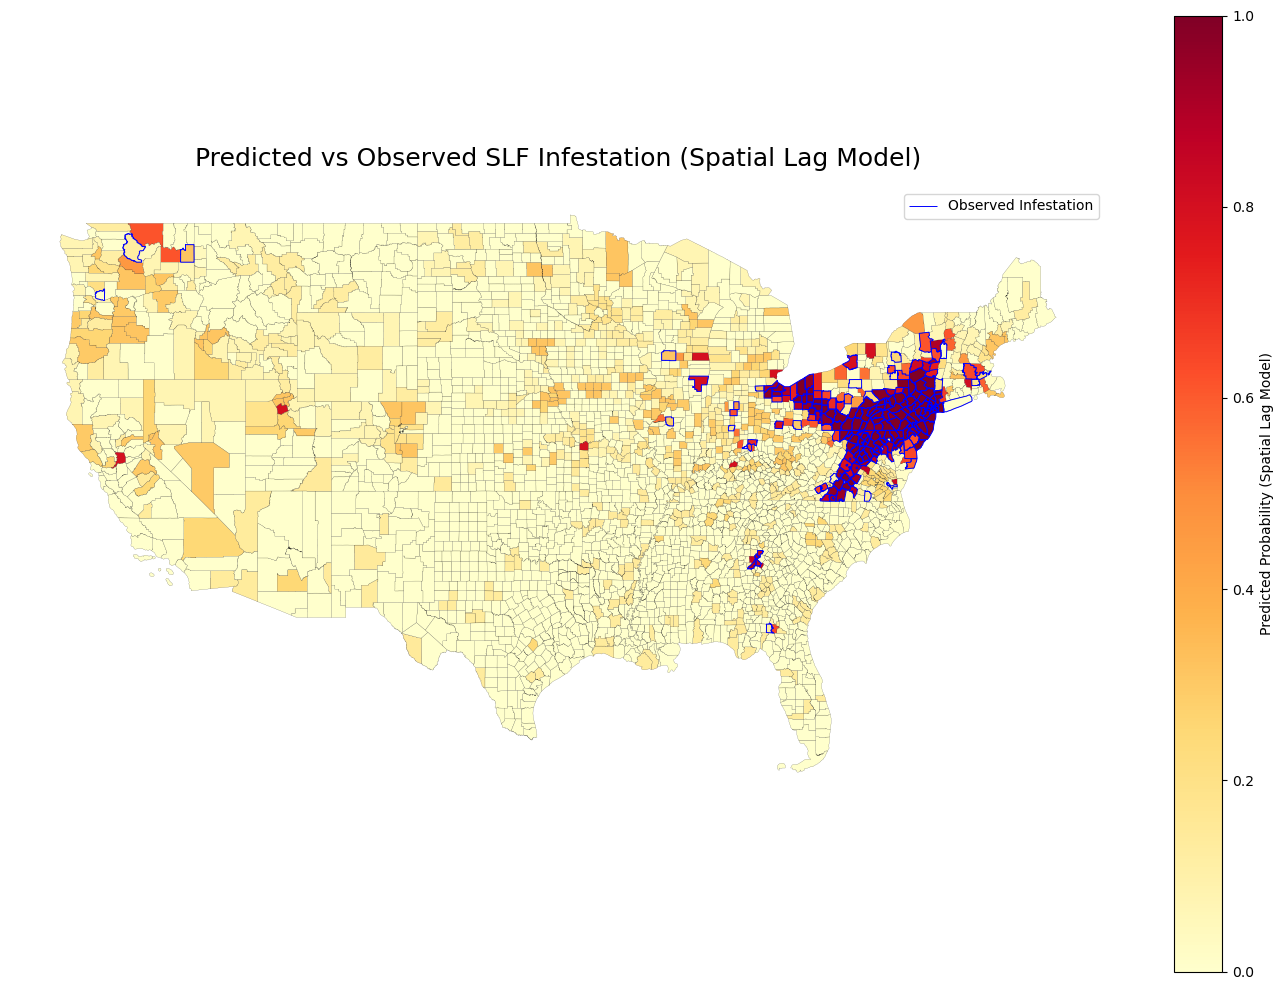

In [26]:

# Plot spatial lag model
fig, ax = plt.subplots(figsize=(14, 10))

conus_gdf.plot(
    column="predicted_proba_spatial",
    cmap="YlOrRd",
    linewidth=0.1,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Predicted Probability (Spatial Lag Model)"},
    ax=ax
)

conus_gdf[conus_gdf["infested"] == 1].boundary.plot(
    ax=ax, color="blue", linewidth=0.7, label="Observed Infestation"
)

ax.set_title("Predicted vs Observed SLF Infestation (Spatial Lag Model)", fontsize=18, pad=15)
ax.legend()
ax.axis("off")
plt.tight_layout()
plt.show()

In [27]:
# Compare results for experiments

# Drop missing values to align data
df_eval = features_df.dropna(subset=["infested", "predicted_proba", "predicted_proba_env", "predicted_proba_spatial"])

# Compute metrics
def evaluate_model(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    return {
        "AUC": roc_auc_score(y_true, y_pred_proba),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
    }

metrics = {
    "Coordinates": evaluate_model(df_eval["infested"], df_eval["predicted_proba"]),
    "Environment Only": evaluate_model(df_eval["infested"], df_eval["predicted_proba_env"]),
    "Spatial Lag": evaluate_model(df_eval["infested"], df_eval["predicted_proba_spatial"]),
}

metrics_df = pd.DataFrame(metrics).T
print(metrics_df.round(3))

                    AUC  Precision  Recall     F1
Coordinates       0.995      0.966   0.947  0.957
Environment Only  0.883      0.250   0.737  0.373
Spatial Lag       0.978      0.791   0.890  0.838


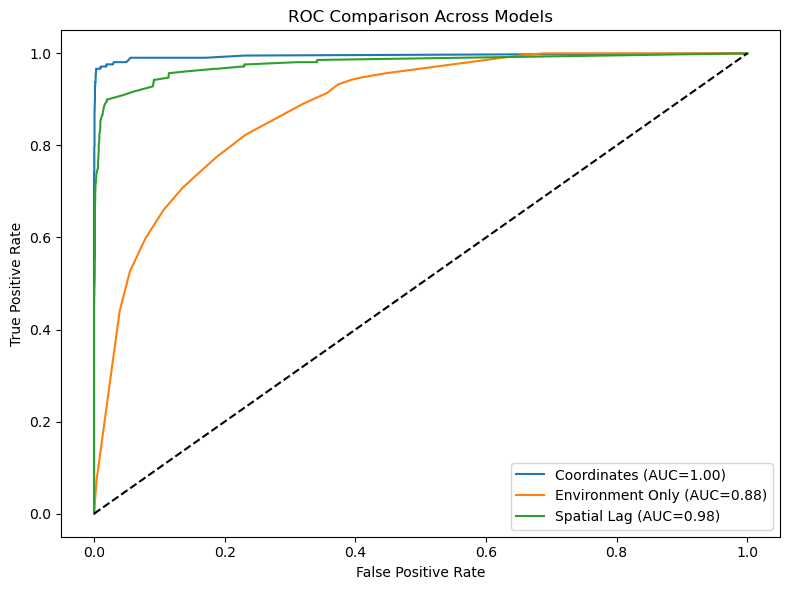

In [28]:
# Plot ROC for all models
plt.figure(figsize=(8, 6))

for label, col in [
    ("Coordinates", "predicted_proba"),
    ("Environment Only", "predicted_proba_env"),
    ("Spatial Lag", "predicted_proba_spatial")
]:
    fpr, tpr, _ = roc_curve(df_eval["infested"], df_eval[col])
    auc = roc_auc_score(df_eval["infested"], df_eval[col])
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison Across Models")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
# Round metrics and format neatly
results_table = (
    metrics_df[["AUC", "Precision", "Recall", "F1"]]
    .round(3)
    .reset_index()
    .rename(columns={"index": "Model"})
)

display(results_table)

,Model,AUC,Precision,Recall,F1
0,Coordinates,0.995,0.966,0.947,0.957
1,Environment Only,0.883,0.250,0.737,0.373
2,Spatial Lag,0.978,0.791,0.890,0.838
